<a href="https://colab.research.google.com/github/lukrak2002/projekt/blob/main/projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Predykcja Cen Nieruchomości**

Współtwórcy - Jakub Majzoub, Yelyzaveta Merliuk, Łukasz Rakoczy

#I Część

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


In [ ]:
file_path = "NY-House-Dataset.csv"

try:
    df = pd.read_csv(file_path, delimiter=",", quoting=3, on_bad_lines='skip')
    print("Plik wczytany poprawnie.")
except pd.errors.ParserError as e:
    print(f"Błąd parsowania CSV: {e}")
    line_number = int(str(e).split("line ")[1].split(",")[0])

    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i == line_number - 1:
                print(f"Problematic line {line_number}: {line.strip()}")
                break


    try:
        df = pd.read_csv(file_path, delimiter=";")
        print("Plik wczytany poprawnie z separatorem ';'.")
    except Exception as e:
        print(f"Nie udało się wczytać pliku nawet z innym separatorem: {e}")

# Wyświetl pierwsze 5 wierszy dla sprawdzenia
print(df.head())

Plik wczytany poprawnie.
                                                                                                                                                                                                              BROKERTITLE;TYPE;PRICE;BEDS;BATH;PROPERTYSQFT;ADDRESS;STATE;MAIN_ADDRESS;ADMINISTRATIVE_AREA_LEVEL_2;LOCALITY;SUBLOCALITY;STREET_NAME;LONG_NAME;FORMATTED_ADDRESS;LATITUDE;LONGITUDE
Brokered by Douglas Elliman  -111 Fifth Ave;Con... NY 10022;2 E 55th St Unit 803New York              NY 10022;New York County;New York;Manhattan;Eas... 2 E 55th St #803 New York NY 10022                                            USA;40.761255;-73.9744834                                                                                                                                  
Brokered by Serhant;Condo for sale;195000000;7;... NY 10019;Central Park Tower Penthouse-217 W 57t... NY 10019;United States;New York;New York County... New York         NY 10019 USA;40.7663935;-73.980

In [ ]:
df.shape

(4783, 1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4783 entries, ('Brokered by Douglas Elliman  -111 Fifth Ave;Condo for sale;315000;2;2;1400;2 E 55th St Unit 803;New York', ' NY 10022;2 E 55th St Unit 803New York', ' NY 10022;New York County;New York;Manhattan;East 55th Street;Regis Residence;Regis Residence', ' 2 E 55th St #803', ' New York', ' NY 10022') to ('Brokered by Nyc Realty Brokers Llc;Co-op for sale;349000;1;1;750;460 Neptune Ave Apt 14O;Brooklyn', ' NY 11224;460 Neptune Ave Apt 14OBrooklyn', ' NY 11224;New York;Kings County;Brooklyn;Coney Island;460;460 Neptune Ave #14a', ' Brooklyn', ' NY 11224', ' USA;40.579147;-73.9709488')
Data columns (total 1 columns):
 #   Column                                                                                                                                                                                Non-Null Count  Dtype 
---  ------                                                                                                    

In [ ]:
df = pd.read_csv(file_path, sep=';')

df.columns = df.columns.str.lower()
df.drop_duplicates(inplace=True)

columns_to_drop = [
    'address',
    'state',
    'main_address',
    'administrative_area_level_2',
    'locality',
    'street_name',
    'long_name',
    'latitude',
    'longitude'
]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')


df.to_csv('przetworzony_plik.csv', index=False)

print(df.shape)
print(df.columns)
print(df.head(100))

(4587, 8)
Index(['brokertitle', 'type', 'price', 'beds', 'bath', 'propertysqft',
       'sublocality', 'formatted_address'],
      dtype='object')
                                           brokertitle                type  \
0          Brokered by Douglas Elliman  -111 Fifth Ave      Condo for sale   
1                                  Brokered by Serhant      Condo for sale   
2                               Brokered by Sowae Corp      House for sale   
3                                  Brokered by COMPASS      Condo for sale   
4    Brokered by Sotheby's International Realty - E...  Townhouse for sale   
..                                                 ...                 ...   
96      Brokered by Douglas Elliman - 3544 Johnson Ave      Co-op for sale   
97                              Brokered by Sowae Corp      House for sale   
98           Brokered by Americas Real Estate Advisors      House for sale   
99       Brokered by Douglas Elliman - 575 Madison Ave      House for sal

In [ ]:
# sort

df_sorted = df.sort_values(by='price')
print(df_sorted.head(100))


                                brokertitle            type   price  beds  \
317     Brokered by Living NY - Main Office        For sale    2494     2   
310     Brokered by Living NY - Main Office        For sale    3225     3   
360     Brokered by Century 21 Realty First   Land for sale    5800     3   
463    Brokered by Morris Park Realty Group  Co-op for sale   49500     3   
979                     Brokered by COMPASS  Condo for sale   60000     3   
...                                     ...             ...     ...   ...   
1527  Brokered by Keller Williams Ny Realty  Co-op for sale  170000     2   
1135              Brokered by Pride Estates         Pending  172800     1   
3948   Brokered by Goldstone N Y Realty Llc  Co-op for sale  173000     3   
1517         Brokered by TRACEY REAL ESTATE  Co-op for sale  174000     1   
1468         Brokered by Pantiga Group Inc.  Co-op for sale  175000     1   

          bath  propertysqft sublocality  \
317   1.000000   2184.207862   

In [ ]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.strip('_')
        df[col] = df[col].str.strip('-')
        df[col] = df[col].replace(' ', np.nan)
df.info()
print(df.head(100))

<class 'pandas.core.frame.DataFrame'>
Index: 4587 entries, 0 to 4800
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brokertitle        4587 non-null   object 
 1   type               4587 non-null   object 
 2   price              4587 non-null   int64  
 3   beds               4587 non-null   int64  
 4   bath               4587 non-null   float64
 5   propertysqft       4587 non-null   float64
 6   sublocality        4587 non-null   object 
 7   formatted_address  4587 non-null   object 
dtypes: float64(2), int64(2), object(4)
memory usage: 322.5+ KB
                                           brokertitle                type  \
0          Brokered by Douglas Elliman  -111 Fifth Ave      Condo for sale   
1                                  Brokered by Serhant      Condo for sale   
2                               Brokered by Sowae Corp      House for sale   
3                                  Brokered

In [ ]:
for col in ['bath', 'propertysqft']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['bath'] = df['bath'].astype(str).str.rstrip('0').str.rstrip('.')
df['propertysqft'] = df['propertysqft'].astype(str).str.rstrip('0').str.rstrip('.')

df['price'] = df['price'].astype(str)

print(df.head(100))

                                           brokertitle                type  \
0          Brokered by Douglas Elliman  -111 Fifth Ave      Condo for sale   
1                                  Brokered by Serhant      Condo for sale   
2                               Brokered by Sowae Corp      House for sale   
3                                  Brokered by COMPASS      Condo for sale   
4    Brokered by Sotheby's International Realty - E...  Townhouse for sale   
..                                                 ...                 ...   
96      Brokered by Douglas Elliman - 3544 Johnson Ave      Co-op for sale   
97                              Brokered by Sowae Corp      House for sale   
98           Brokered by Americas Real Estate Advisors      House for sale   
99       Brokered by Douglas Elliman - 575 Madison Ave      House for sale   
100                   Brokered by Brown Harris Stevens      Co-op for sale   

         price  beds                bath propertysqft      subl

In [ ]:
print(df.head(500))

                                           brokertitle  \
0          Brokered by Douglas Elliman  -111 Fifth Ave   
1                                  Brokered by Serhant   
2                               Brokered by Sowae Corp   
3                                  Brokered by COMPASS   
4    Brokered by Sotheby's International Realty - E...   
..                                                 ...   
511                        Brokered by B Square Realty   
512                   Brokered by Exit Alliance Realty   
513          Brokered by Corcoran Williamsburg Bedford   
514                        Brokered by B Square Realty   
515              Brokered by TALK OF THE TOWN REALTY C   

                           type      price  beds                bath  \
0                Condo for sale     315000     2                   2   
1                Condo for sale  195000000     7                  10   
2                House for sale     260000     4                   2   
3              

In [ ]:
df['type'] = df['type'].str.replace('for sale', '', regex=False)

In [ ]:
print(df.head(100))

                                           brokertitle        type      price  \
0          Brokered by Douglas Elliman  -111 Fifth Ave      Condo      315000   
1                                  Brokered by Serhant      Condo   195000000   
2                               Brokered by Sowae Corp      House      260000   
3                                  Brokered by COMPASS      Condo       69000   
4    Brokered by Sotheby's International Realty - E...  Townhouse    55000000   
..                                                 ...         ...        ...   
96      Brokered by Douglas Elliman - 3544 Johnson Ave      Co-op     1295000   
97                              Brokered by Sowae Corp      House      245000   
98           Brokered by Americas Real Estate Advisors      House      400000   
99       Brokered by Douglas Elliman - 575 Madison Ave      House    55000000   
100                   Brokered by Brown Harris Stevens      Co-op      280000   

     beds                ba

In [ ]:
# prompt: usuń kolumny brokertitle i formatted_address

columns_to_drop = ['brokertitle', 'formatted_address','address']
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')


In [ ]:
le_type = LabelEncoder()
le_sublocality = LabelEncoder()

df['type'] = le_type.fit_transform(df['type'])
df['sublocality'] = le_sublocality.fit_transform(df['sublocality'])

for class_label, original_value in enumerate(le_type.classes_):
    print(f"Type: {class_label} represents: {original_value}")
for class_label, original_value in enumerate(le_sublocality.classes_):
    print(f"Sublocality: {class_label} represents: {original_value}")

Type: 0 represents: Co-op 
Type: 1 represents: Coming Soon
Type: 2 represents: Condo 
Type: 3 represents: Condop 
Type: 4 represents: Contingent
Type: 5 represents: For sale
Type: 6 represents: Foreclosure
Type: 7 represents: House 
Type: 8 represents: Land 
Type: 9 represents: Mobile house 
Type: 10 represents: Multi-family home 
Type: 11 represents: Pending
Type: 12 represents: Townhouse 
Sublocality: 0 represents: Bronx County
Sublocality: 1 represents: Brooklyn
Sublocality: 2 represents: Brooklyn Heights
Sublocality: 3 represents: Coney Island
Sublocality: 4 represents: Dumbo
Sublocality: 5 represents: East Bronx
Sublocality: 6 represents: Flushing
Sublocality: 7 represents: Fort Hamilton
Sublocality: 8 represents: Jackson Heights
Sublocality: 9 represents: Kings County
Sublocality: 10 represents: Manhattan
Sublocality: 11 represents: New York
Sublocality: 12 represents: New York County
Sublocality: 13 represents: Queens
Sublocality: 14 represents: Queens County
Sublocality: 15 rep

In [ ]:
print(df.head(100))

     type      price  beds                bath propertysqft  sublocality
0       2     315000     2                   2         1400           10
1       2  195000000     7                  10        17545           12
2       7     260000     4                   2         2015           16
3       2      69000     3                   1          445           12
4      12   55000000     7  2.3738608579684373        14175           12
..    ...        ...   ...                 ...          ...          ...
96      0    1295000     4                   2         1995           20
97      7     245000     3                   1  2184.207862            0
98      7     400000     7                   3         2385            0
99      7   55000000     8                   8        12000           12
100     0     280000     1                   1         1000            1

[100 rows x 6 columns]


In [ ]:
df_sorted = df.sort_values(by='price')
print(df_sorted.head(4000))

      type     price  beds bath propertysqft  sublocality
3705    11    100000     3    1          445           13
1336     0    100000     3    1          512           13
4645     7   1000000     8    3  2184.207862            0
2821     2   1000000     1    1          773           11
2758    10  10000000     7    8  2184.207862           12
...    ...       ...   ...  ...          ...          ...
985      7    800000     3    2  2184.207862           14
2012    10    805000     6    2         2042            0
4665     0   8100000     5    4         4000           11
4632     2    815000     3    2         1039            1
2094     0    815000     1    1          630           11

[4000 rows x 6 columns]


In [ ]:
df.dtypes

,0
type,float64
price,float64
beds,float64
bath,float64
propertysqft,float64
sublocality,float64


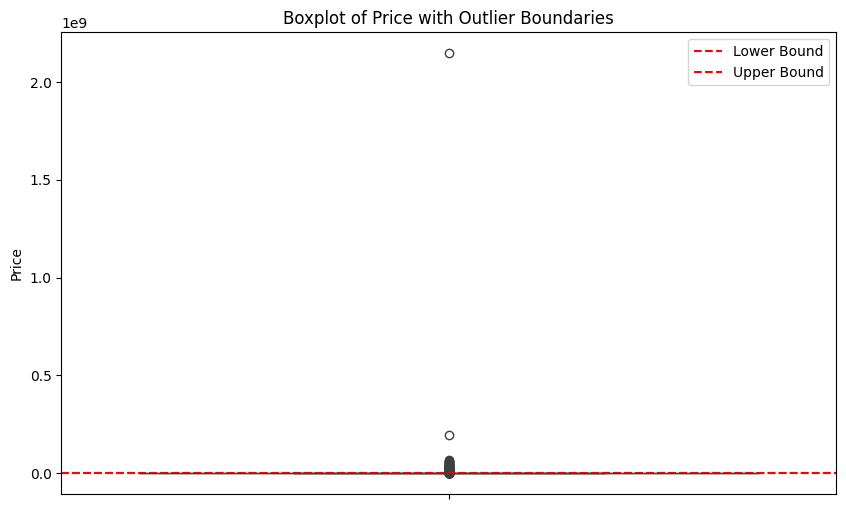

In [ ]:
df['price'] = pd.to_numeric(df['price'], errors='coerce')

plt.figure(figsize=(10, 6))
sns.boxplot(y='price', data=df)

# Calculate outlier boundaries
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Add red lines for outlier boundaries
plt.axhline(y=lower_bound, color='r', linestyle='--', label='Lower Bound')
plt.axhline(y=upper_bound, color='r', linestyle='--', label='Upper Bound')

plt.title('Boxplot of Price with Outlier Boundaries')
plt.ylabel('Price')
plt.legend()
plt.show()


<ipython-input-19-5facede0581d>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '903426.7164326189' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[(df['price'] < lower_bound) | (df['price'] > upper_bound), 'price'] = mean_price


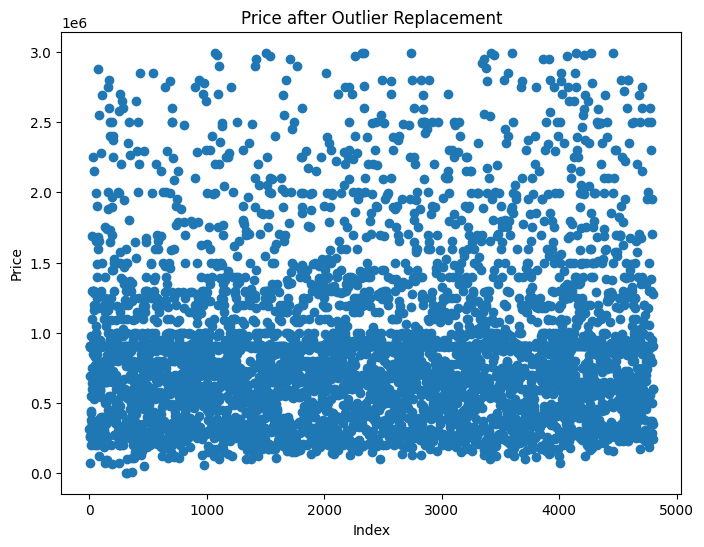

In [ ]:
# Zastąpienie wartości odstających w 'price' średnią
mean_price = df['price'][(df['price'] >= lower_bound) & (df['price'] <= upper_bound)].mean()
df.loc[(df['price'] < lower_bound) | (df['price'] > upper_bound), 'price'] = mean_price

# Wykres po usunięciu wartości odstających
plt.figure(figsize=(8, 6))
plt.plot(df['price'], marker='o', linestyle='')
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Price after Outlier Replacement')
plt.show()

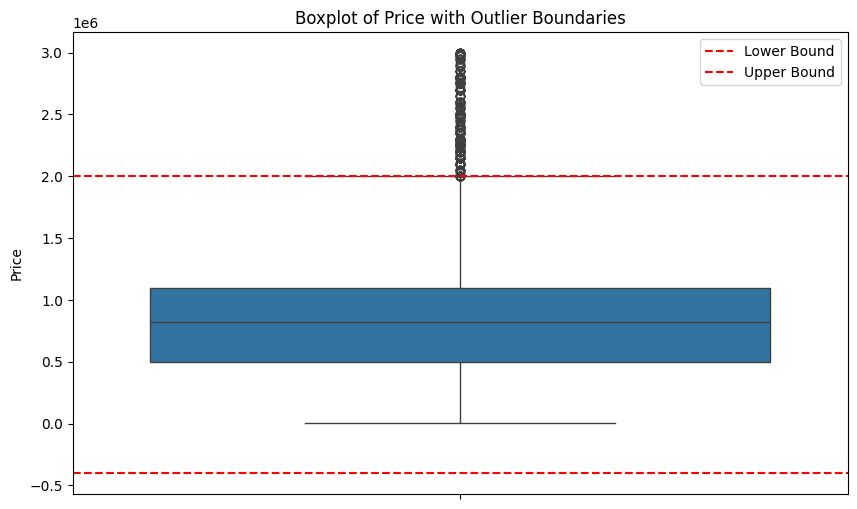

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='price', data=df)

# Calculate outlier boundaries
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Add red lines for outlier boundaries
plt.axhline(y=lower_bound, color='r', linestyle='--', label='Lower Bound')
plt.axhline(y=upper_bound, color='r', linestyle='--', label='Upper Bound')

plt.title('Boxplot of Price with Outlier Boundaries')
plt.ylabel('Price')
plt.legend()
plt.show()

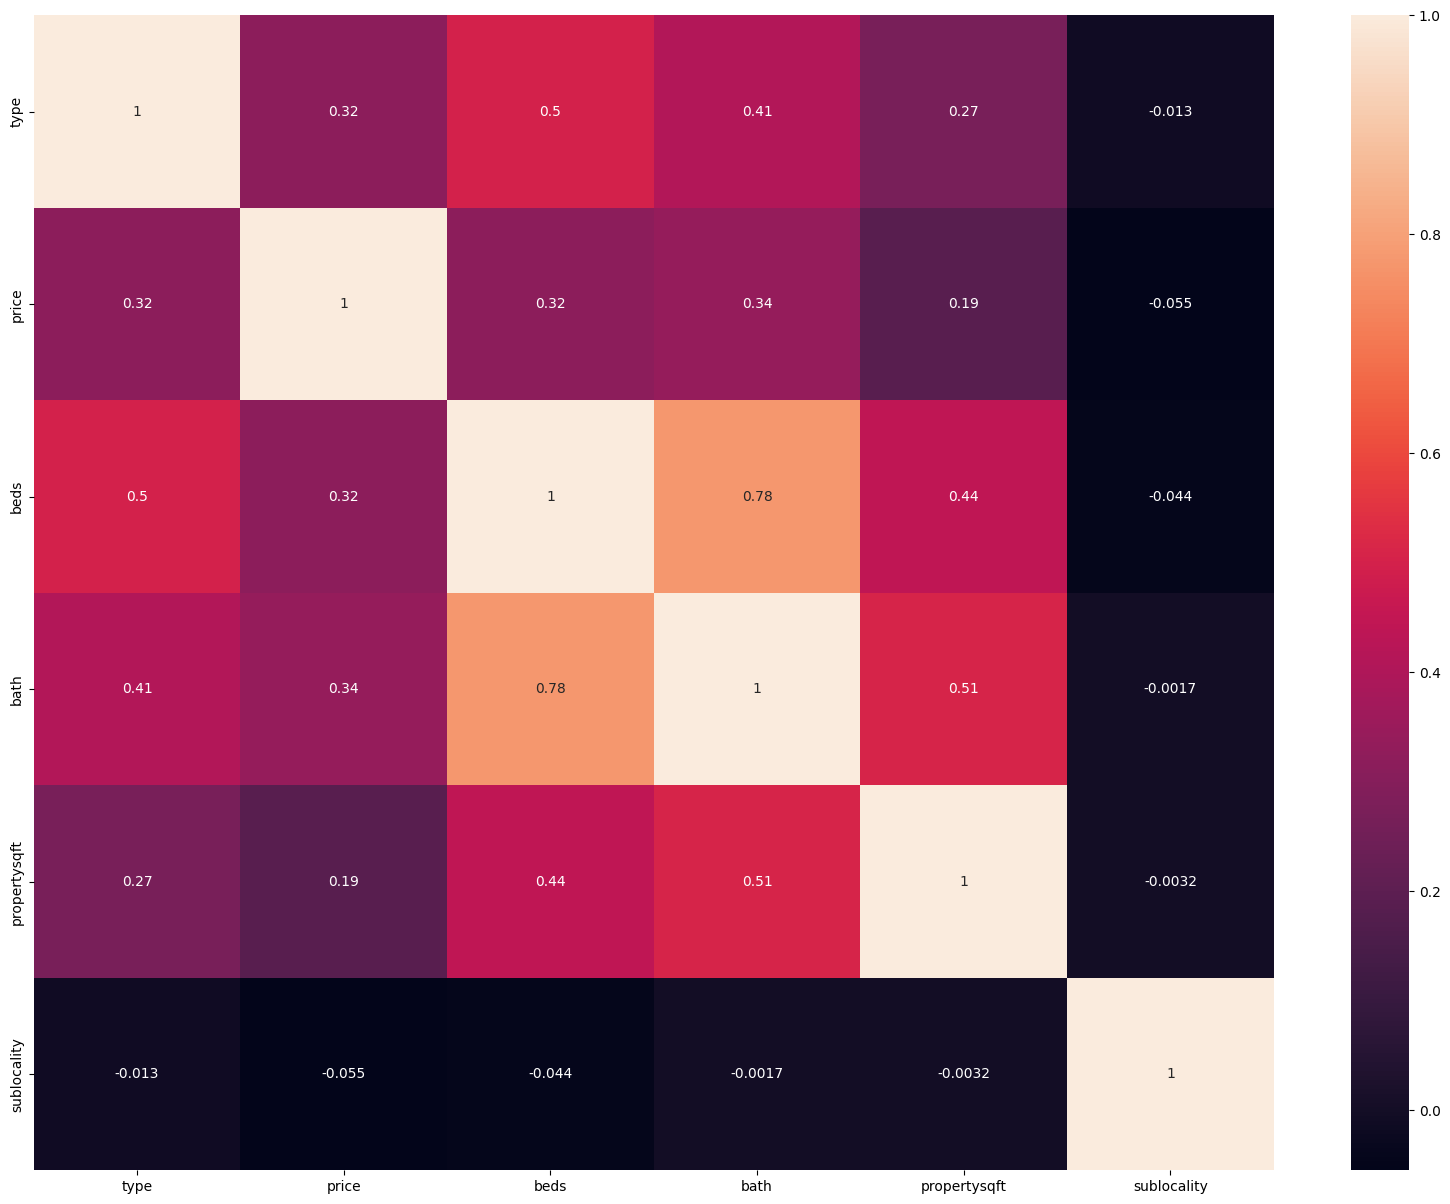

In [ ]:
corr_matrix = df.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True)
plt.show()

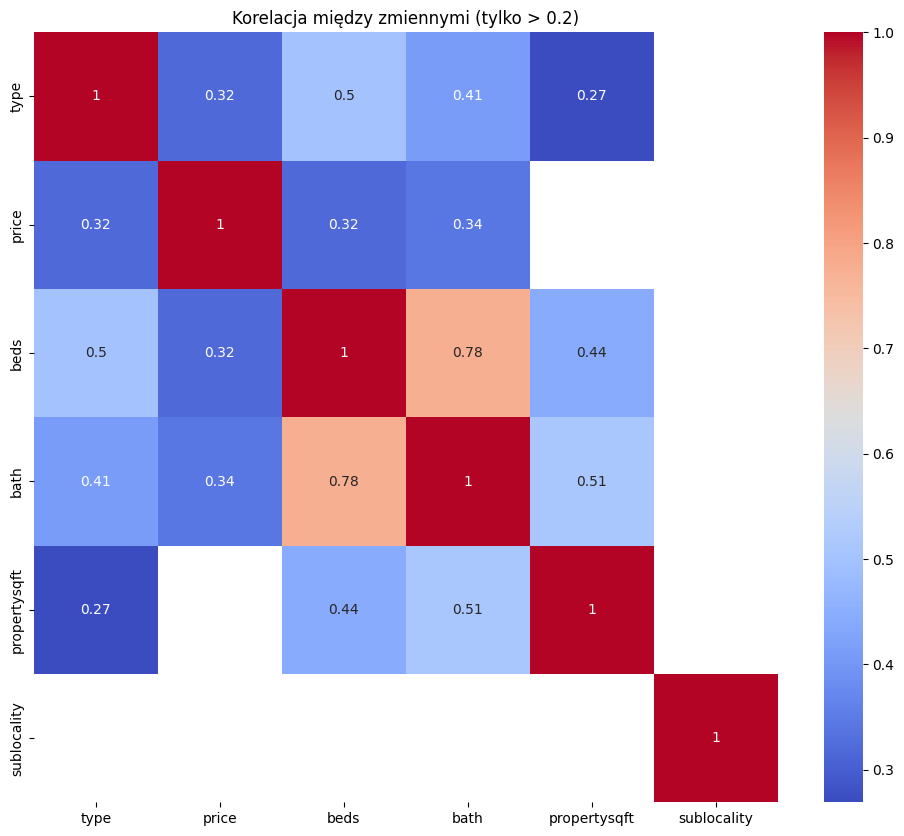

In [ ]:
#Pokaz korelacje między zmiennymi tylko jesli są większe od 0.2
corr_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix[abs(corr_matrix) > 0.2], annot=True, cmap='coolwarm')
plt.title('Korelacja między zmiennymi (tylko > 0.2)')
plt.show()

#StandardScaler

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
col_float = ['type', 'price', 'beds', 'bath', 'propertysqft', 'sublocality']

for i in df[col_float]:
  df[i] = scaler.fit_transform(df[[i]])

print(df.head())

       type         price      beds      bath  propertysqft  sublocality
0 -0.661130 -1.010566e+00 -0.519614 -0.191911     -0.340677    -0.134148
1 -0.661130  2.852907e-16  1.382596  3.872535      6.731634     0.256789
2  0.490375 -1.105023e+00  0.241270 -0.191911     -0.071276     1.038664
3 -0.661130 -1.433048e+00 -0.139172 -0.699966     -0.759014     0.256789
4  1.641879  2.852907e-16  1.382596 -0.001968      5.255407     0.256789


#MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
col_float = ['type', 'price', 'beds', 'bath', 'propertysqft',
       'sublocality']

for i in df[col_float]:
  df[i] = scaler.fit_transform(df[[i]])

print(df.head())

       type     price      beds      bath  propertysqft  sublocality
0  0.166667  0.104430  0.020408  0.040000      0.017916          0.5
1  0.166667  0.301063  0.122449  0.200000      0.265140          0.6
2  0.583333  0.086050  0.061224  0.040000      0.027333          0.8
3  0.166667  0.022224  0.040816  0.020000      0.003292          0.6
4  1.000000  0.301063  0.122449  0.047477      0.213536          0.6


#RobustScaler

In [ ]:
from sklearn.preprocessing import RobustScaler

   scaler = RobustScaler()
   col_float = ['type', 'price', 'beds', 'bath', 'propertysqft', 'sublocality']

   for i in df[col_float]:
       df[i] = scaler.fit_transform(df[[i]])

In [36]:
print(df)

          type         price      beds      bath  propertysqft  sublocality
0    -0.661130 -1.010566e+00 -0.519614 -0.191911     -0.340677    -0.134148
1    -0.661130  2.852907e-16  1.382596  3.872535      6.731634     0.256789
2     0.490375 -1.105023e+00  0.241270 -0.191911     -0.071276     1.038664
3    -0.661130 -1.433048e+00 -0.139172 -0.699966     -0.759014     0.256789
4     1.641879  2.852907e-16  1.382596 -0.001968      5.255407     0.256789
...        ...           ...       ...       ...           ...          ...
4796 -1.121732 -5.228236e-01 -0.900056 -0.699966      0.002845     0.061321
4797 -1.121732 -1.130784e+00 -0.900056 -0.699966      0.002845     0.647727
4798 -1.121732  6.381413e-01 -0.900056 -0.699966      0.002845     0.256789
4799 -0.661130 -5.243263e-01 -0.519614 -0.699966     -0.667024     0.452258
4800 -1.121732 -9.521745e-01 -0.900056 -0.699966     -0.625409    -1.893364

[4587 rows x 6 columns]


In [37]:
df.dtypes

,0
type,float64
price,float64
beds,float64
bath,float64
propertysqft,float64
sublocality,float64


# II Cześć

Model podstawowy jako wybrany benchmark, wybranie metod oceny modelu, wyznaczenie danych uczących i testowych

**Model podstawowy**

In [38]:
df.columns

Index(['type', 'price', 'beds', 'bath', 'propertysqft', 'sublocality'], dtype='object')

In [39]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.preprocessing import StandardScaler

train and test data

In [40]:
X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [41]:
regressor = LinearRegression().fit(X_train, y_train)

In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

# Przewidywanie na zbiorze testowym
y_pred = regressor.predict(X_test)

# Obliczanie miar
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Wypisywanie wyników
print(f"Średni błąd kwadratowy (MSE): {mse:.2f}")
print(f"Średni błąd absolutny (MAE): {mae:.2f}")
print(f"Wynik wyjaśnionej wariancji (EVS): {evs:.2f}")
print(f"Współczynnik determinacji (R^2): {r2:.2f}")

Średni błąd kwadratowy (MSE): 0.87
Średni błąd absolutny (MAE): 0.67
Wynik wyjaśnionej wariancji (EVS): 0.16
Współczynnik determinacji (R^2): 0.16


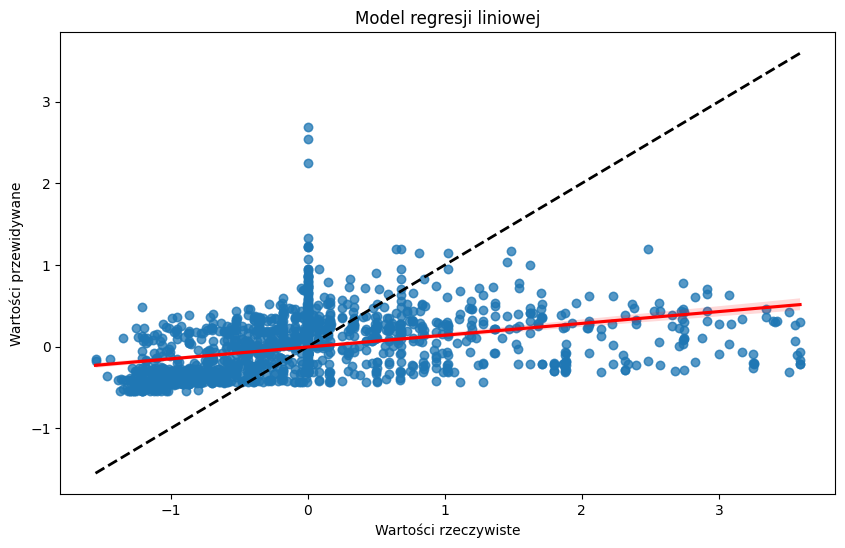

In [43]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.xlabel('Wartości rzeczywiste')
plt.ylabel('Wartości przewidywane')
plt.title('Model regresji liniowej')
plt.show()